In [1]:
import sys
sys.path.append('../')

import numpy as np 
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

# Importing the marcia package

%load_ext autoreload
%autoreload 2
from marcia import Cosmology
from marcia import Data
from marcia import Kernels
from marcia import params

## Example set-up for the Gaussian process kernel

In [2]:
# The kernel class is initialised with the model, parameters and data 
k = Kernels(['SE', 'SE', 'SE'], [1, 1, 1, 1, 1, 1], [np.linspace(0, 1, 60), np.linspace(0, 1, 100), np.linspace(0, 1, 80)])

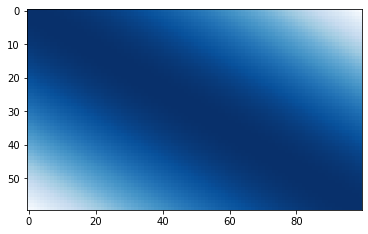

In [7]:
auto_check = k.kernel('M92', [1,2], k.data[1], k.data[1])
cross_check = k.cross_kernel('SE', 'SE',  [1,2], [1,2], k.data[0], k.data[1])
plt.imshow(cross_check, cmap ='Blues') 

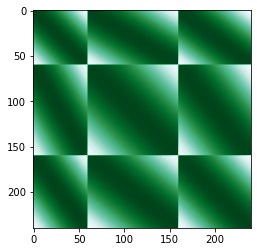

In [8]:
# To plot the full covariance matrix
plt.imshow(k.Cov_Mat(), cmap='BuGn')

# To validate with the data

In [9]:
d = Data(['CC'])
x,y, cov = d()
print(len(x))
hyper_params = [100,10]

k = Kernels(['SE'], hyper_params, [x])

Nuisance parameters are set to default values
31


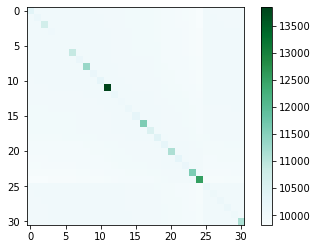

In [10]:
plt.imshow(k.Cov_Mat()+cov, cmap='BuGn')
plt.colorbar()

In [11]:
d2 = Data(['CC', 'SNE'])
x2,y2, cov2 = d2()
hyper_params = [100,100, 10, 10]

Nuisance parameters are set to default values


In [12]:
d2.x

{'x0': array([0.0708, 0.09  , 0.12  , 0.17  , 0.1791, 0.1993, 0.2   , 0.27  ,
        0.28  , 0.3519, 0.4   , 0.48  , 0.5929, 0.6797, 0.7812, 0.8754,
        0.88  , 0.9   , 1.037 , 1.3   , 1.363 , 1.43  , 1.53  , 1.75  ,
        1.965 , 0.3802, 0.4004, 0.4247, 0.4497, 0.4783, 0.47  ]),
 'x1': array([0.07, 0.2 , 0.35, 0.55, 0.9 , 1.5 ])}

In [45]:
k2 = Kernels(['SE', 'SE'], hyper_params, list(d2.x.values()))

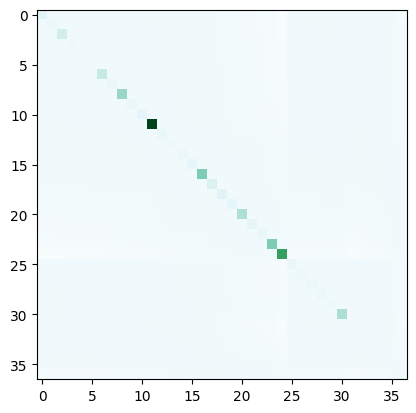

In [47]:
plt.imshow(k2.Cov_Mat() + cov2, cmap='BuGn')